## Importing Required Libraries


In [1]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from PIL import Image
import pandas as pd
import numpy as np
import cv2
import os
tf.config.set_visible_devices([], 'GPU')

## Assigning Path for Dataset


In [2]:
data_dir = './'
train_path = 'Train'
test_path = 'Test'

# For resizing the images to 30x30x3
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

## Class Names


In [3]:
classes = ['Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)', 'End of speed limit (80km/h)', 'Speed limit (100km/h)', 'Speed limit (120km/h)', 'No passing',
           'No passing veh over 3.5 tons', 'Right-of-way at intersection', 'Priority road', 'Yield', 'Stop', 'No vehicles', 'Veh > 3.5 tons prohibited', 'No entry', 'General caution', 'Dangerous curve left', 'Dangerous curve right', 'Double curve', 'Bumpy road',
           'Slippery road', 'Road narrows on the right', 'Road work', 'Traffic signals', 'Pedestrians', 'Children crossing', 'Bicycles crossing', 'Beware of ice/snow', 'Wild animals crossing', 'End speed + passing limits', 'Turn right ahead', 'Turn left ahead',
           'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 'Keep left', 'Roundabout mandatory', 'End of no passing', 'End no passing veh > 3.5 tons']

## Visualizing The Dataset


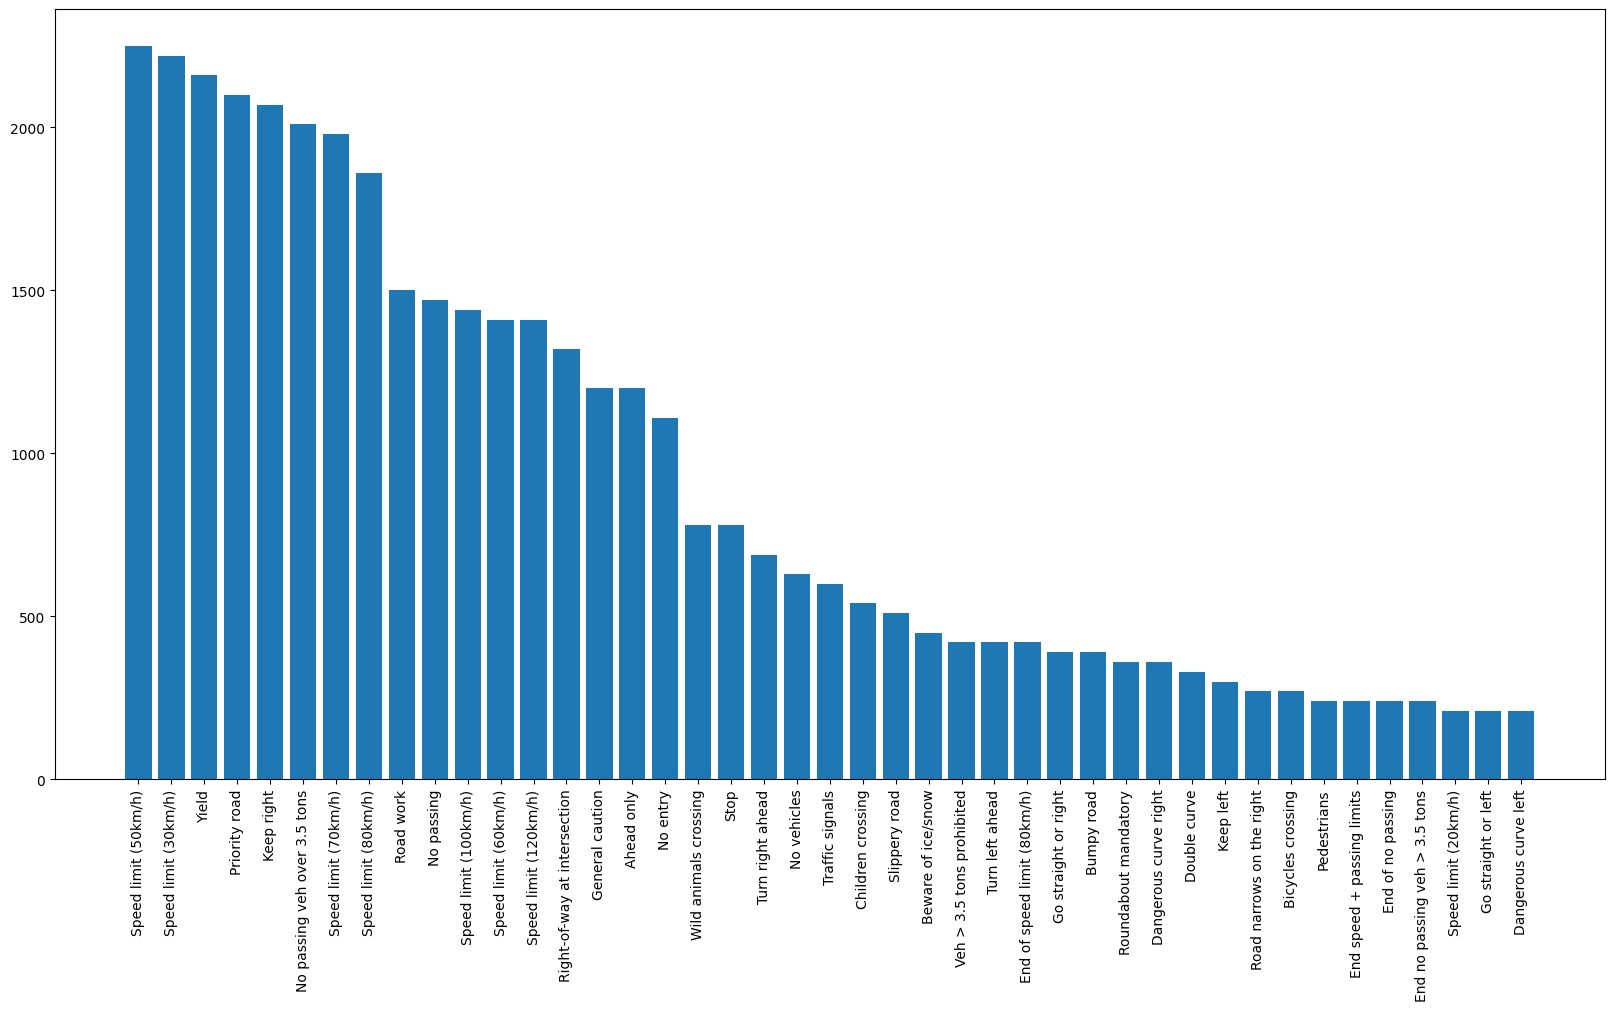

In [4]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])

# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists, reverse=True)
tuples = zip(*sorted_pairs)
train_number, class_num = [list(tuple) for tuple in tuples]

# Plotting the number of images in each class
plt.figure(figsize=(20, 10))
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

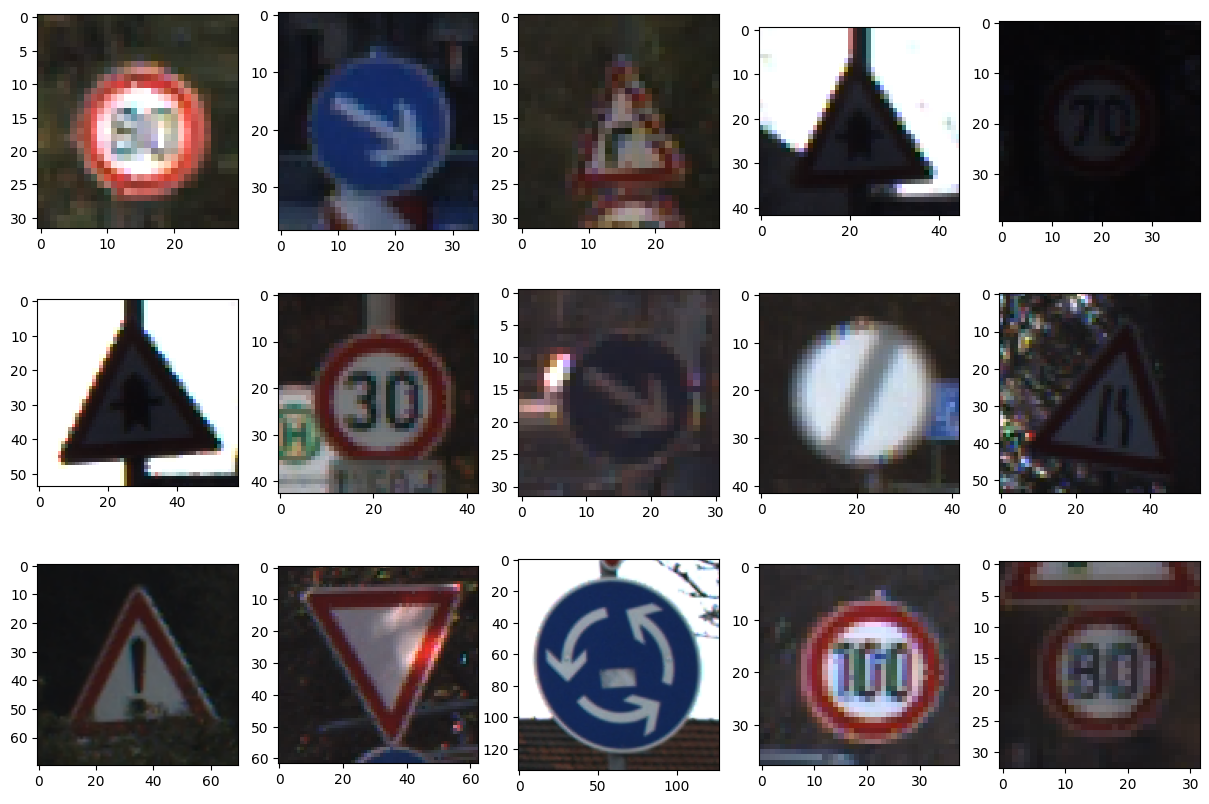

In [5]:
# Visualizing 15 random images from test data
import random
from matplotlib.image import imread

test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(15, 10))

for i in range(1, 16):
    plt.subplot(3, 5, i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(False)

## Collecting the Training Data


In [6]:
image_data = []
image_labels = []

for i in range(43):
    path = 'Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 30, 30, 3) (39209,)


## Shuffling the Training Data


In [7]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

## Splitting the data into Train and Validation set


In [8]:
X_train, X_val, y_train, y_val = train_test_split(
    image_data, image_labels, test_size=0.2)

X_train = X_train/255
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (31367, 30, 30, 3)
X_valid.shape (7842, 30, 30, 3)
y_train.shape (31367,)
y_valid.shape (7842,)


## One hot encoding the labels


In [9]:
y_train = keras.utils.to_categorical(y_train, 43)
y_val = keras.utils.to_categorical(y_val, 43)

print(y_train.shape)
print(y_val.shape)

(31367, 43)
(7842, 43)


## Making the model


In [10]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=16, kernel_size=(
        3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),

    keras.layers.Dense(43, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 13, 13, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 9, 9, 128)         7

## Compiling the model


In [11]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=opt, metrics=['accuracy'])

## Augmenting the data and training the model


In [12]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")
augmented_data = aug.flow(X_train, y_train, batch_size=32)

In [13]:
history = model.fit(augmented_data, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
981/981 [==============================] - 35s 35ms/step - loss: 0.9894 - accuracy: 0.7316 - val_loss: 0.0882 - val_accuracy: 0.9740
Epoch 2/20
981/981 [==============================] - 36s 36ms/step - loss: 0.1738 - accuracy: 0.9471 - val_loss: 0.0794 - val_accuracy: 0.9749
Epoch 3/20
981/981 [==============================] - 36s 37ms/step - loss: 0.1037 - accuracy: 0.9691 - val_loss: 0.0534 - val_accuracy: 0.9830
Epoch 4/20
981/981 [==============================] - 36s 37ms/step - loss: 0.0831 - accuracy: 0.9744 - val_loss: 0.0250 - val_accuracy: 0.9929
Epoch 5/20
981/981 [==============================] - 38s 38ms/step - loss: 0.0751 - accuracy: 0.9767 - val_loss: 0.0429 - val_accuracy: 0.9850
Epoch 6/20
981/981 [==============================] - 37s 38ms/step - loss: 0.0597 - accuracy: 0.9815 - val_loss: 0.0279 - val_accuracy: 0.9916
Epoch 7/20
981/981 [==============================] - 36s 37ms/step - loss: 0.0563 - accuracy: 0.9832 - val_loss: 0.0133 - val_accuracy:

## Evaluating the model


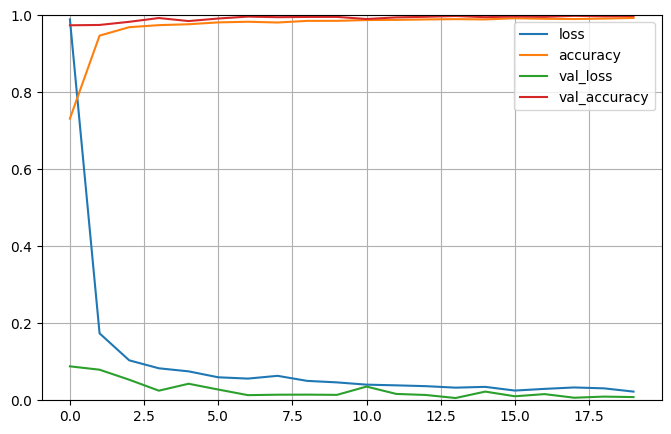

In [14]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## Loading the test data and running the predictions


In [15]:
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data = []

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' + img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

pred = model.predict(X_test)

395/395 [==============================] - 4s 9ms/step


In [16]:
y_pred = np.argmax(pred, axis=1)
y_pred.shape

(12630,)

## Visualizing the confusion matrix


<Axes: >

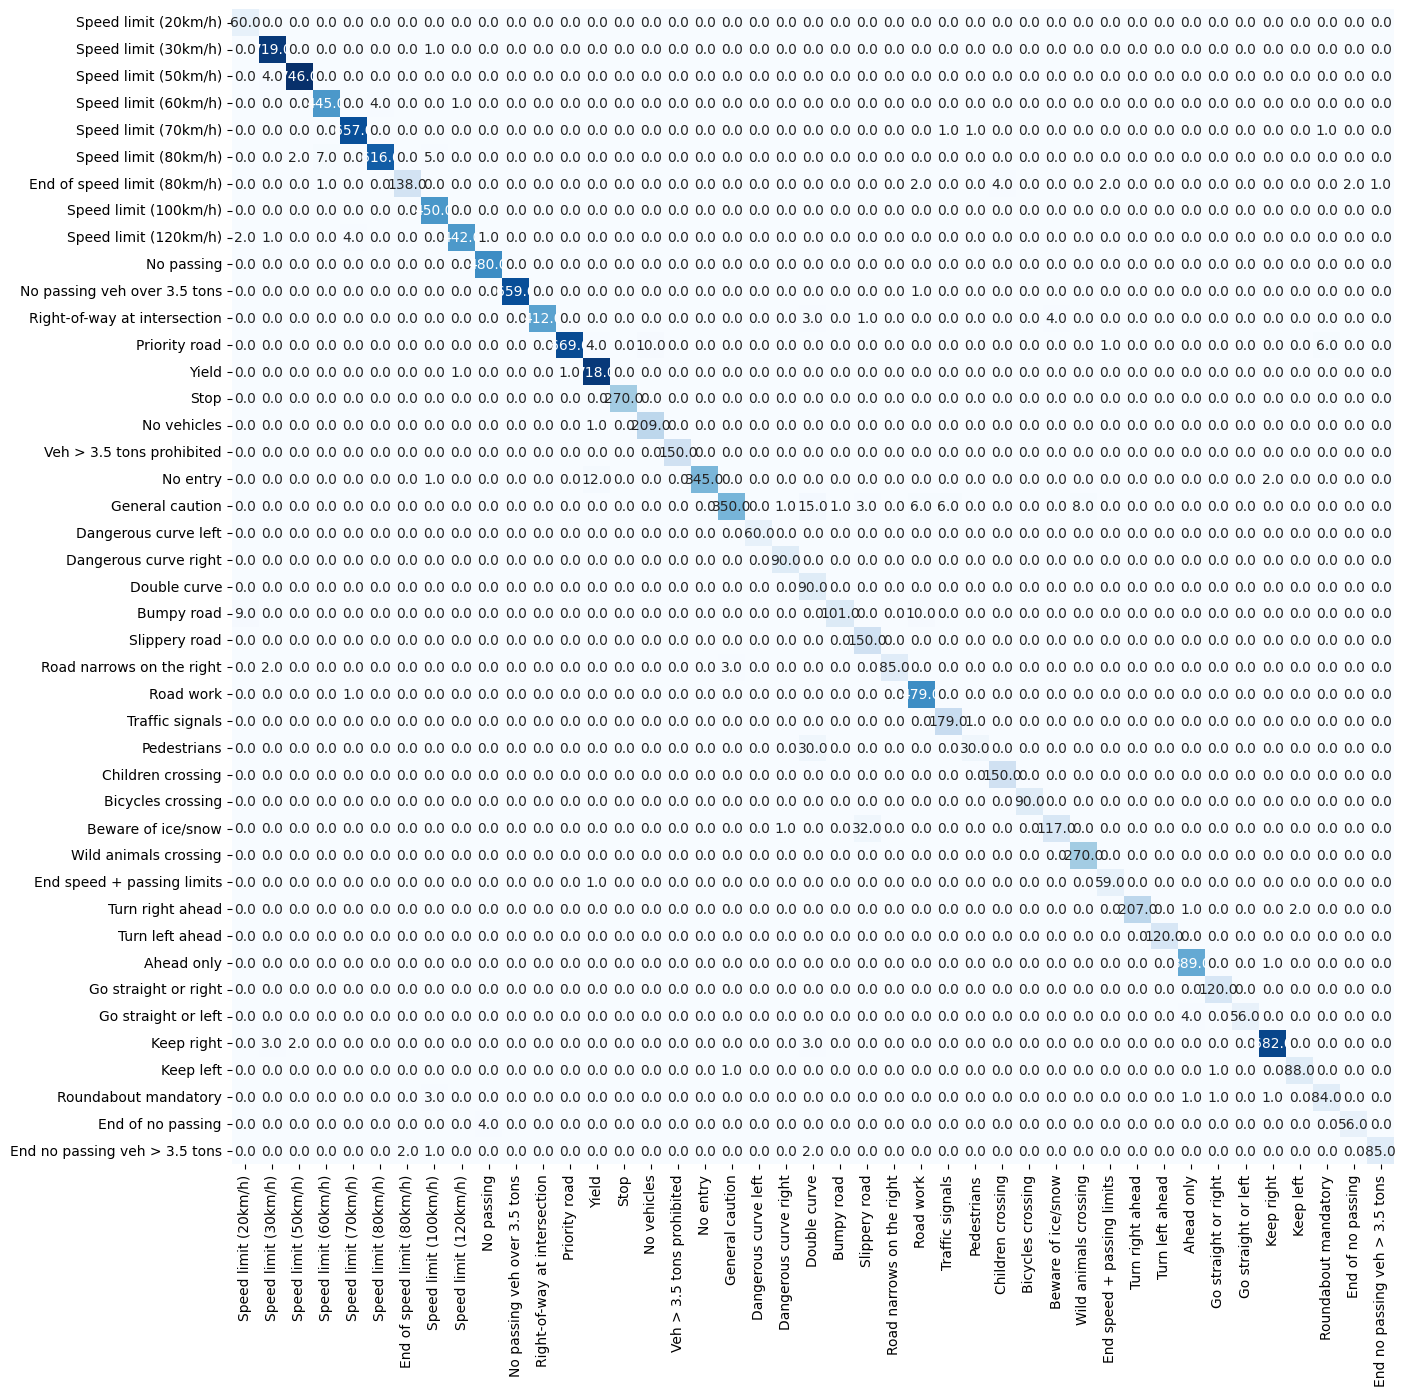

In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(labels, y_pred)
df_cm = pd.DataFrame(cf, index=classes,  columns=classes)
plt.figure(figsize=(15, 15))
sns.heatmap(df_cm, annot=True, cmap='Blues', cbar=False, fmt=".1f")

## Classification report


In [18]:
from sklearn.metrics import classification_report

print(classification_report(labels, y_pred))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92        60
           1       0.99      1.00      0.99       720
           2       0.99      0.99      0.99       750
           3       0.98      0.99      0.99       450
           4       0.99      1.00      0.99       660
           5       0.99      0.98      0.99       630
           6       0.99      0.92      0.95       150
           7       0.98      1.00      0.99       450
           8       1.00      0.98      0.99       450
           9       0.99      1.00      0.99       480
          10       1.00      1.00      1.00       660
          11       1.00      0.98      0.99       420
          12       1.00      0.97      0.98       690
          13       0.98      1.00      0.99       720
          14       1.00      1.00      1.00       270
          15       0.95      1.00      0.97       210
          16       1.00      1.00      1.00       150
          17       1.00    

## Predicting 15 random samples of Test Data


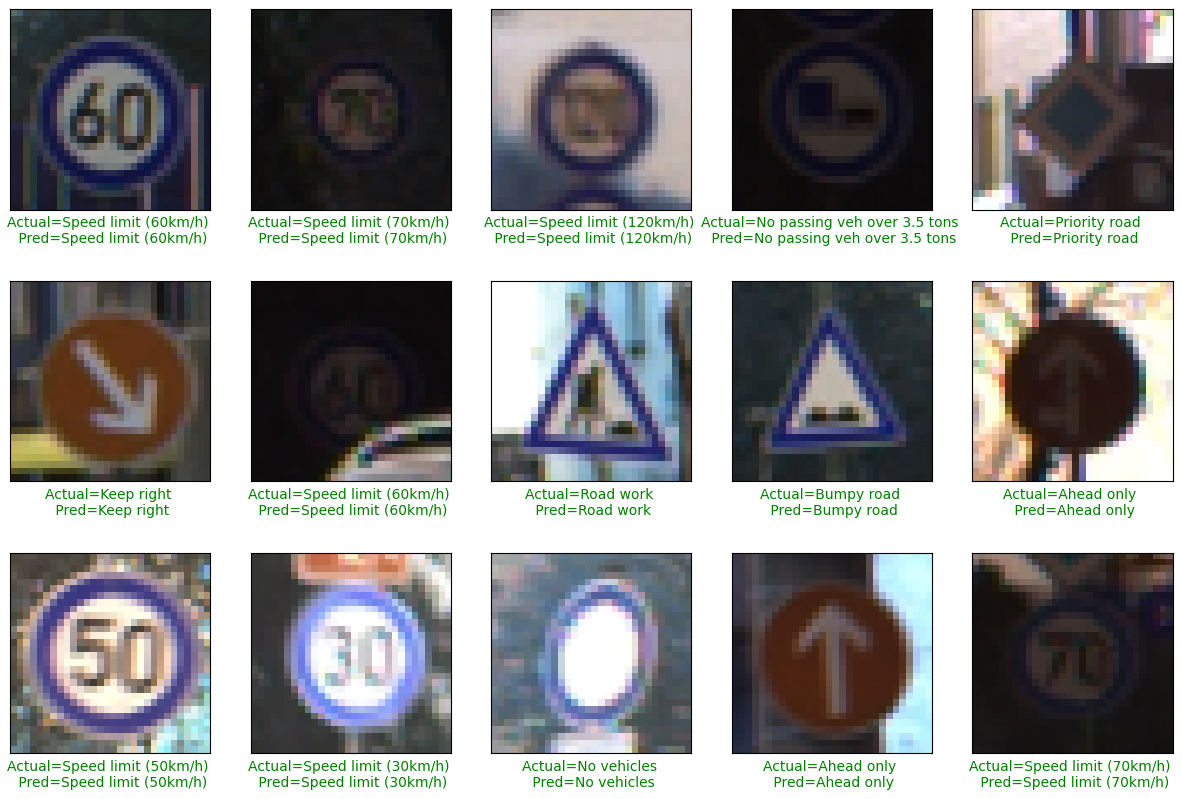

In [19]:
plt.figure(figsize=(15, 10))

for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    rand = random.randint(0, len(labels))
    prediction = y_pred[rand]
    actual = labels[rand]
    plt.xlabel('Actual={} \n Pred={}'.format(
        classes[actual], classes[prediction]), color=('r' if prediction != actual else 'g'))
    plt.imshow(X_test[rand])
plt.show()